In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/fgsm 실습 폴더

/content/drive/MyDrive/fgsm 실습 폴더


In [3]:
!pip install import_ipynb
import import_ipynb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00


In [4]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class SimpleCNN:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# first CONV => RELU => BN layer set
		model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		# second CONV => RELU => BN layer set
		model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

In [5]:
# import the necessary packages
from pyimagesearch.simplecnn import SimpleCNN
from pyimagesearch.fgsm import generate_image_adversary_target
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# load MNIST dataset and scale the pixel values to the range [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data() #MNIST 데이터셋 로드
trainX = trainX / 255.0 #픽셀값을 [0,1] 사이로 정규화 -> 모델의 계산 비용 줄어듦
testX = testX / 255.0
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# 라벨 데이터를 원-핫 인코딩 형태로 변화
# ex) 숫자 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 형태로 변경
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)



# initialize our optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-3)
model = SimpleCNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the simple CNN on MNIST
print("[INFO] training network...")
model.fit(trainX, trainY,validation_data=(testX, testY),batch_size=64,epochs=10,verbose=1)
# make predictions on the testing set for the model trained on
# non-adversarial images
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

importing Jupyter notebook from /content/drive/MyDrive/fgsm 실습 폴더/pyimagesearch/simplecnn.ipynb
importing Jupyter notebook from /content/drive/MyDrive/fgsm 실습 폴더/pyimagesearch/fgsm.ipynb
[INFO] loading MNIST dataset...
11490434/11490434 [==============================] - 0s 0us/step


[INFO] compiling model...
[INFO] training network...
Epoch 1/10
938/938 [==============================] - 34s 34ms/step - loss: 0.1941 - accuracy: 0.9410 - val_loss: 0.0564 - val_accuracy: 0.9808
Epoch 2/10
938/938 [==============================] - 31s 33ms/step - loss: 0.0790 - accuracy: 0.9754 - val_loss: 0.0546 - val_accuracy: 0.9811
Epoch 3/10
938/938 [==============================] - 31s 33ms/step - loss: 0.0559 - accuracy: 0.9830 - val_loss: 0.0455 - val_accuracy: 0.9845
Epoch 4/10
938/938 [==============================] - 31s 33ms/step - loss: 0.0497 - accuracy: 0.9841 - val_loss: 0.0425 - val_accuracy: 0.9855
Epoch 5/10
938/938 [==============================] - 31s 33ms/step - loss: 0.0397 - accuracy: 0.9873 - val_loss: 0.0407 - val_accuracy: 0.9878
Epoch 6/10
938/938 [==============================] - 31s 33ms/step - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.0358 - val_accuracy: 0.9893
Epoch 7/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0291 

1/1 [==============================] - 0s 31ms/step


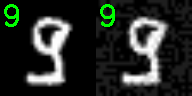

1/1 [==============================] - 0s 39ms/step


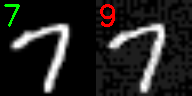

1/1 [==============================] - 0s 29ms/step


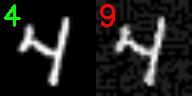

1/1 [==============================] - 0s 21ms/step


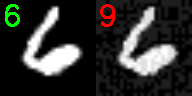

1/1 [==============================] - 0s 23ms/step


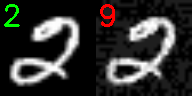

1/1 [==============================] - 0s 23ms/step


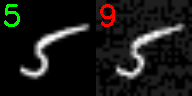

1/1 [==============================] - 0s 30ms/step


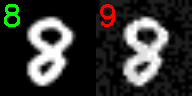

1/1 [==============================] - 0s 20ms/step


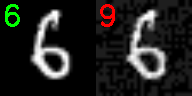

1/1 [==============================] - 0s 26ms/step


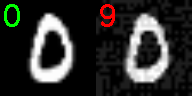

1/1 [==============================] - 0s 22ms/step


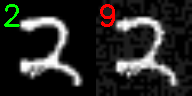

1/1 [==============================] - 0s 20ms/step


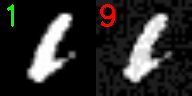

1/1 [==============================] - 0s 21ms/step


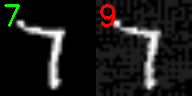

1/1 [==============================] - 0s 21ms/step


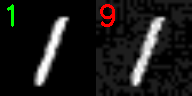

1/1 [==============================] - 0s 21ms/step


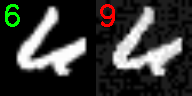

1/1 [==============================] - 0s 22ms/step


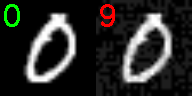

In [17]:
from tensorflow.keras.losses import MSE,categorical_crossentropy
import tensorflow as tf
def generate_image_adversary_targeted(model, image, target_label,eps=2/255.0):
  #이미지 캐스트
  image=tf.cast(image,tf.float32)

  #기울기를 기록한다.
  with tf.GradientTape() as tape: #자동 차별화를 위한 작업을 기록하는 그레디언트 테이프를 생성함
    #이미지를 수정해야함을 명시적으로 나타낸다
    tape.watch(image)

    #입력이미지를 예측하기 위해 우리의 모델을 쓴다
    #손실을 계산한다
    pred=model(image)
    target_loss=categorical_crossentropy(target_label,pred)#타겟 라벨 대한 손실을 계산

    # 이미지에 대한 손실 기울기를 계산한다
    gradient=tape.gradient(target_loss,image)
    signed_grad=tf.sign(gradient)#기울기의 부호를 계산한다

    # 타겟 적대적 이미지를 생성함
    adversary=(image-(signed_grad*eps)).numpy() # 이 부분이 원본과 다르다.
    # 위락 원하는 타겟이미지에 손실을 낮춘다.

    #적대적 이미지 예시를 반환
    return adversary


target=np.array([0,0,0,0,0,0,0,0,0,1]).reshape(1, 10)

# loop over a sample of our testing images
for i in np.random.choice(np.arange(0, len(testX)), size=(15,)):
	# grab the current image and label
	image = testX[i]
	label = testY[i]
	# generate an image adversary for the current image and make
	# a prediction on the adversary
	adversary = generate_image_adversary_targeted(model,
		image.reshape(1, 28, 28, 1), target, eps=30/255.0)
	pred = model.predict(adversary)

 	# scale both the original image and adversary to the range
	# [0, 255] and convert them to an unsigned 8-bit integers
	adversary = adversary.reshape((28, 28)) * 255
	adversary = np.clip(adversary, 0, 255).astype("uint8")
	image = image.reshape((28, 28)) * 255
	image = image.astype("uint8")
	# convert the image and adversarial image from grayscale to three
	# channel (so we can draw on them)
	image = np.dstack([image] * 3)
	adversary = np.dstack([adversary] * 3)
	# resize the images so we can better visualize them
	image = cv2.resize(image, (96, 96))
	adversary = cv2.resize(adversary, (96, 96))
	# determine the predicted label for both the original image and
	# adversarial image
	imagePred = label.argmax()
	adversaryPred = pred.argmax()
	color = (0, 255, 0)
	# if the image prediction does not match the adversarial
	# prediction then update the color
	if imagePred != adversaryPred:
		color = (0, 0, 255)
	# draw the predictions on the respective output images
	cv2.putText(image, str(imagePred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
	cv2.putText(adversary, str(adversaryPred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
	# stack the two images horizontally and then show the original
	# image and adversarial image
	output = np.hstack([image, adversary])
	cv2_imshow(output)
	cv2.waitKey(0)


In [ ]:
ls

cifar-fgsm.ipynb                fgsm_adversarial.ipynb  pyimagesearch/
fgsm_adversarial_Cifar10.ipynb  fgsm_target.ipynb
